# Atoti Lookup Function — Currency Conversion  

In most of the use cases, we have demonstrated how we could join tables to the cube to perform multidimensional analysis. For instance, in the data schema below, we have joined the _FX rate_ table to the base table _Equities_.

<img src="https://data.atoti.io/notebooks/currency-conversion-with-lookup/img/joined_tables.png" />

The FX rate shows 1 USD to value in the corresponding currency. So, in this case, we will be able to translate the price of the equity from the native currency to USD. __What if we would also like to have the flexibility to view price in another currency that is available in the FX list?__  

<br/>

<img src="https://data.atoti.io/notebooks/currency-conversion-with-lookup/img/reference_value.gif" />
  
<br/> 

Now, there are many ways to achieve that, and one of it, is to use Atoti's new [lookup function](https://docs.atoti.io/latest/api/atoti.lookup.html#atoti.lookup) (refer to [Atoti v0.7.1 changelog](https://docs.atoti.io/latest/releases/0.7.1.html)). Follow us through this notebook to understand how you can make use of the lookup function to retrieve value from a standalone table!

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=currency-conversion-with-lookup" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
import atoti as tt
import pandas as pd

## Getting started

This section is a short recap on the basic of getting started with Atoti. We will get a simple BI analytics platform that allow us to start analyzing the historical pricing of the equities.  

### Instantiate Atoti session  

Let's start by instantiating our Atoti session! As we have prepared a simple dashboard for this use case, we need the [user_content_storage](https://docs.atoti.io/latest/api/atoti.UserContentStorageConfig.html#atoti.UserContentStorageConfig) to persist the dashboard.

In [2]:
session = tt.Session.start(tt.SessionConfig(user_content_storage="./content"))

/Users/aya/Desktop/atoti/.venv/lib/python3.11/site-packages/atoti/session.py:468: RuntimeWarning: The license key is about to expire, contact ActiveViam to get a new license key in the coming 5 days.
  session._warn_if_license_about_to_expire()


### Create base table — Equities  

We obtained the historical pricing for three different equities from [Kaggle](https://www.kaggle.com/datasets/sandhyakrishnan02/deutsche-bank-equity-nyq-ger-and-fra-from-2010) but we transform the closing price into an array so as to reduce the data size. We extracted the dates for the data separately for later use.  

In [3]:
equity_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/lookup/equity.csv",
    table_name="Equities",
    keys=["Equity name"],
    array_separator=",",
    data_types={"Price": tt.type.DOUBLE_ARRAY},
)
equity_tbl.head()

,Currency,Price
Equity name,,
NYQ,USD,"[38.005726, 36.860687, 34.57061, 32.099236, 33..."
GER,EUR,"[26.116592, 25.218515, 23.805428, 22.443415, 2..."
FRA,EUR,"[25.949652, 25.431541, 24.203907, 22.332251, 2..."


### Create cube  

In this use case, we are going to create the cube with [*no_measures* mode](https://docs.atoti.io/latest/api/atoti.Session.create_cube.html#atoti.Session.create_cube), just so that we can focus on what we needed.  

In [4]:
cube = session.create_cube(equity_tbl, mode="no_measures")

### Create parameter hierarchy for historical dates  

From the equities data previously, we extracted the corresponding dates. We will make use of the [`create_parameter_hierarchy_from_members` function](https://docs.atoti.io/latest/api/atoti.Cube.create_parameter_hierarchy_from_members.html#atoti.Cube.create_parameter_hierarchy_from_members) to create the _Date_ hierarchy, as well as a _Date Index_ measure.  

The _Date Index_ measure will help us reconcile between the Price array and the dates.

In [5]:
calendar = pd.read_csv("https://data.atoti.io/notebooks/lookup/equity_dates.csv")[
    "Date"
]

cube.create_parameter_hierarchy_from_members(
    "Dates",
    list(calendar),
    index_measure_name="Date Index",
)

### Manipulate hierarchies, levels and measures

In [6]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

#### Hierarchies - Slicing 

By setting [slicing](https://docs.atoti.io/latest/api/atoti.Hierarchy.slicing.html#atoti.Hierarchy.slicing) on `h["Dates"]`, this allow us to look at the first date by default whenever we query the cube.  

In [7]:
h["Dates"].slicing = True

#### Levels - Ordering

With slicing, we want to look at the latest date by default. By setting the `NaturalOrder` to `ascending=False`, the dates will be sorted in descending order. Therefore, the first returned member will be the latest date.

In [8]:
l["Dates"].order = tt.NaturalOrder(ascending=False)

#### Measures - Creating measure from table   

We can apply [aggregation functions](https://docs.atoti.io/latest/api/atoti.agg.html) on table columns directly as shown below. The [`single_value` function](https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value) will return a measure only if the value is the same for all members of the level the operand is being aggregated on.

In [9]:
price = tt.agg.single_value(equity_tbl["Price"])

#### Measures - Working with vectors
  
We use the `m["Date Index"]` from the parameter hierarchy as a pointer to the array.

In [10]:
m["Daily price"] = price[m["Date Index"]]

### Visualization

We see the prices for the equities. However, the chart is not very accurate as the pricing is based on different currencies.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
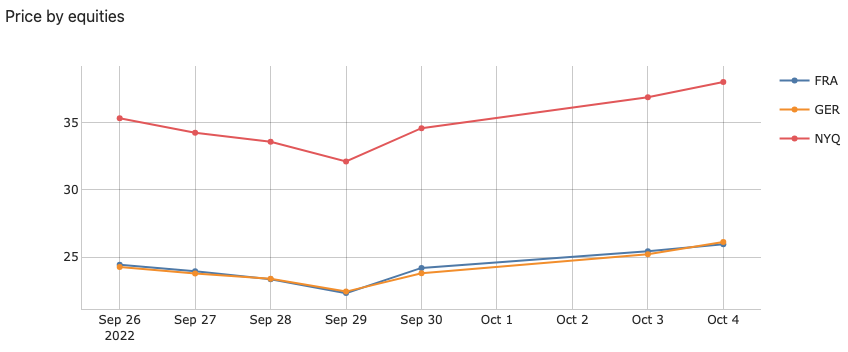

In [11]:
session.widget

## Creating standalone table

We create a standalone table the same way as other Atoti tables. __However, it is important to note that in order for us to perform lookup, this table must have a key.__  

The FX rate is modified from [Kaggle's US Dollar Exchange Rates dataset](https://www.kaggle.com/datasets/cvengr/us-dollar-exchange-rates).

In [12]:
fx_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/lookup/fx_rates.csv",
    table_name="Fx_rates",
    array_separator=",",
    keys=["Currency"],
)
fx_tbl.head()

,Rates
Currency,
EUR,"[1.002286, 1.019629, 1.021677, 1.02296, 1.0329..."
GBP,"[0.87388, 0.887196, 0.898448, 0.904977, 0.9239..."
CHF,"[0.980753, 0.993042, 0.98435, 0.979608, 0.9760..."
JPY,"[144.321465, 144.498033, 144.715574, 144.44153..."
CAD,"[1.355457, 1.365132, 1.375103, 1.369885, 1.365..."


__We will not perform any join to the base table.__   

Let's use `session.tables.schema` to review the cube schema.  We will be able to see the *Fx_rates* table is not connected.

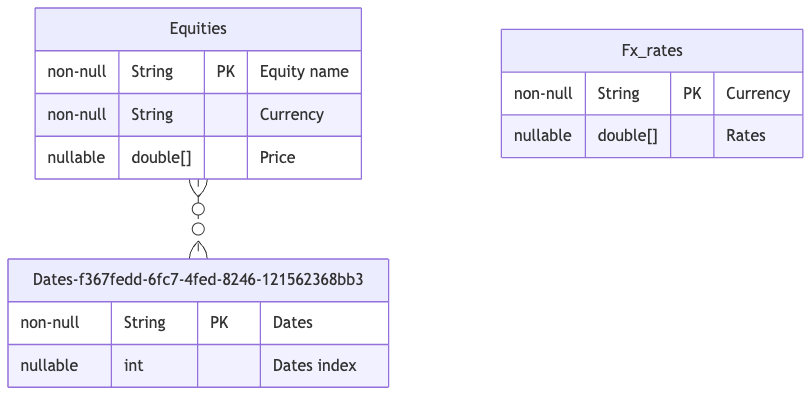

In [13]:
session.tables.schema

## Creating lookup measures  

### Computing Price in USD
  
We will compare the *cube's level* against *column value of the standalone table* to lookup against. In this case, we return the rates of the currency that matches the equity's currency.  

In [14]:
m["Lookup rate"] = tt.lookup(fx_tbl["Rates"], fx_tbl["Currency"] == l["Currency"])

Since the rate is the corresponding value for 1 USD in the selected currency, we can safely set the rate to 1 when the currency is "USD". Otherwise, we retrieve the corresponding rate value in the array.

In [15]:
m["USD rate"] = tt.where(l["Currency"] == "USD", 1, m["Lookup rate"][m["Date Index"]])
m["USD rate"].formatter = "DOUBLE[##.0000]"

We are ready to perform the conversion!  
  
💡 **Note:** Without using lookup, the below can also be easily achieved by joining the *Fx_rates* table to the *Equities* table on *Date* and *Currency*.

In [16]:
m["Price (USD)"] = tt.agg.sum(
    m["Daily price"] / m["USD rate"], scope=tt.OriginScope(levels={l["Currency"]})
)
m["Price (USD)"].formatter = "DOUBLE[#,##0.0000]"

Notice that we perform an aggregation over the *Currency* scope above? In the event where we want to query `Price (USD)` without the `Currency` level in scope, the measure will return the summation of the formula `m["Daily price"] / m["USD rate"]` at the underlying `Currency` level.

Try creating the measure with `m["Price (USD)"] = m["Daily price"] / m["USD rate"]` and run the below query again to see the difference. 

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
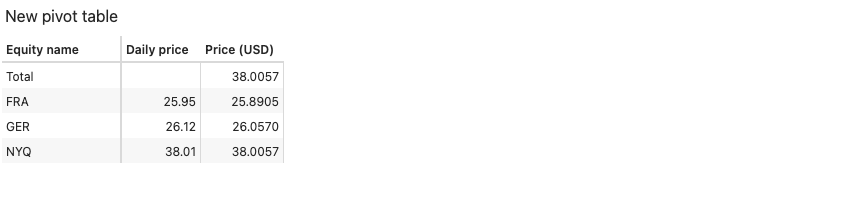

In [17]:
session.widget

### Computing Price in other currencies  

#### Creating Reference Currency  

We will need the currencies under the *Fx_rates* table to be members that can be queries. Making use of the [`create_parameter_hierarchy_from_column` function](https://docs.atoti.io/latest/api/atoti.Cube.create_parameter_hierarchy_from_column.html#atoti.Cube.create_parameter_hierarchy_from_column), we can create a factless hierarchy which in our case, is named as *Reference currency*. There is no corresponding facts in the cube for these currencies. 

In [18]:
cube.create_parameter_hierarchy_from_column("Reference currency", fx_tbl["Currency"])

In [19]:
fx_tbl.head()

,Rates
Currency,
EUR,"[1.002286, 1.019629, 1.021677, 1.02296, 1.0329..."
GBP,"[0.87388, 0.887196, 0.898448, 0.904977, 0.9239..."
CHF,"[0.980753, 0.993042, 0.98435, 0.979608, 0.9760..."
JPY,"[144.321465, 144.498033, 144.715574, 144.44153..."
CAD,"[1.355457, 1.365132, 1.375103, 1.369885, 1.365..."


#### Associating rates with Reference currency 

Using `atoti.lookup`, we look up the `Rates` in the standalone *Fx_rates* table when the `Reference currency` matches the currency in the table.  

💡 **Note:** We apply the rates on `m["Price (USD)"]` instead of `m["Daily Price"]`.

In [20]:
m["Lookup reference rate"] = tt.lookup(
    fx_tbl["Rates"], fx_tbl["Currency"] == l["Reference currency"]
)
m["Reference rate"] = tt.where(
    l["Reference currency"] == "USD", 1, m["Lookup reference rate"][m["Date Index"]]
)

m["Reference rate"].formatter = "DOUBLE[#,##0.0000]"

#### Computing price in Reference currency

Now we can easily apply the FX conversion.  

In [21]:
m["Reference price"] = m["Price (USD)"] * m["Reference rate"]
m["Reference price"].formatter = "DOUBLE[#,##0.0000]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
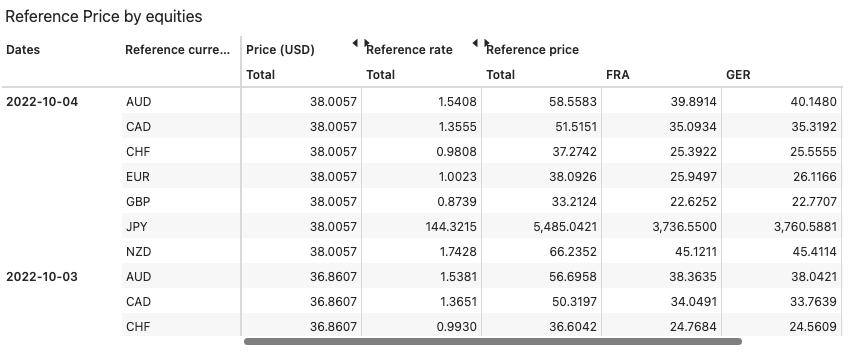

In [22]:
session.widget

## Changing currency interactively in Atoti  

Using the quick filter widget, we can easily change from one currency to another. Give it a try in the following dashboard!

In [23]:
session.link / "#/dashboard/7d0"

http://localhost:56158/#/dashboard/7d0

## Conclusion

In the above use case, we used members of a level to perform lookup on the standalone table. But we are not limited to level comparisons. Instead, try using measure values to perform a lookup conditionally!

__Unable to achieve what you need? Reach out to us on [GitHub discussion](https://github.com/atoti/atoti/discussions) or contact [ActiveViam](https://www.activeviam.com/contact-us/) for a demonstration!__ 

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=currency-conversion-with-lookup" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>